In [1]:
import sys
import pandas as pd
import numpy as np
import re
import collections
import pickle
import string
import dateutil.parser as parser
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")

In [3]:
from textblob import TextBlob
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.summarization import summarize

2017-12-24 12:40:58,085 : INFO : Could not import Theano, will use standard float for default ShardedCorpus dtype.
2017-12-24 12:40:58,102 : INFO : 'pattern' package not found; tag filters are not available for English


In [4]:
df = pd.read_csv('TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv')

In [5]:
len(df)

2475

# Preprocessing and summarization

In [6]:
# Count words after stripping times and pauses
df['text'] = df.transcript.map(lambda x: re.sub(r'[0-9]+:[0-9]+', '', str(x)))

stopwords = ['(Laughter)', '(Applause)']
for i in stopwords:
        df['text'] = df.text.map(lambda x: x.replace(i, ''))
        
df['words_n'] = df.text.map(lambda x: len(x.split()))

In [7]:
# Exclude those with no text
df = df[df['words_n'] > 1].reset_index(drop=True)

In [8]:
# Create 2 'clean' versions - 'transcript' preserves laughter/applause
df['text_clean'] = df.text.map(lambda x: re.sub(r'[\r]+', ' ', x)).map(lambda x: ' '.join(x.split()))
df['transcript_clean'] = df.transcript.map(lambda x: re.sub(r'[\r]+', ' ', str(x))).map(lambda x: ' '.join(x.split()))

In [9]:
df.text_clean[0][:400]

"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. Put yourselves in my position. I flew on Air Force Two for ei"

In [12]:
df['summary'] = None

for i in range(len(df)):
    try:
        df['summary'][i] = summarize(df.text_clean[i], ratio = 0.05, word_count=None, split=False)
    except:
        df['summary'][i] = 'ERROR'

df['summary'] = df.summary.map(lambda x: re.sub(r'[\n]+', ' ', x))
df = df[df.summary != 'ERROR' ].reset_index(drop=True)

2017-12-24 12:41:51,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:41:51,470 : INFO : built Dictionary(492 unique tokens: ['thank', 'chri', 'truli', 'great', 'honor']...) from 132 documents (total 825 corpus positions)
/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
2017-12-24 12:41:51,793 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:41:51,796 : INFO : built Dictionary(461 unique tokens: ['term', 'invent', 'like', 'tell', 'tale']...) from 150 documents (total 950 corpus positions)
2017-12-24 12:41:52,181 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:41:52,185 : INFO : built Dictionary(543 unique tokens: ['public', 'dewei', 'long', 'ago', 'observ'].

2017-12-24 12:42:08,824 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:08,828 : INFO : built Dictionary(474 unique tokens: ['thought', 'podium', 'bit', 'scare', 'chri']...) from 208 documents (total 1140 corpus positions)
2017-12-24 12:42:09,499 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:09,503 : INFO : built Dictionary(512 unique tokens: ['let', 'imag', 'consid', 'citi', 'tomorrow']...) from 131 documents (total 919 corpus positions)
2017-12-24 12:42:09,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:09,799 : INFO : built Dictionary(572 unique tokens: ['charl', 'van', 'doren', 'later', 'senior']...) from 200 documents (total 1418 corpus positions)
2017-12-24 12:42:10,460 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:10,465 : INFO : built Dictionary(719 unique tokens: ['great', 'heard', 'lot', 'promis', 'technolog']...) from 204 documents (total 17

2017-12-24 12:42:26,919 : INFO : built Dictionary(528 unique tokens: ['got', 'appar', 'minut', 'convinc', 'histori']...) from 154 documents (total 1273 corpus positions)
2017-12-24 12:42:27,293 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:27,297 : INFO : built Dictionary(948 unique tokens: ['know', 'intens', 'pleasur', 'travel', 'delight']...) from 165 documents (total 1654 corpus positions)
2017-12-24 12:42:27,725 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:27,726 : INFO : built Dictionary(137 unique tokens: ['hour', 'present', 'high', 'school', 'student']...) from 44 documents (total 232 corpus positions)
2017-12-24 12:42:27,811 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:27,815 : INFO : built Dictionary(456 unique tokens: ['ask', 'surpris', 'book', 'got', 'write']...) from 207 documents (total 1173 corpus positions)
2017-12-24 12:42:28,434 : INFO : adding document #0 to Diction

2017-12-24 12:42:40,864 : INFO : built Dictionary(476 unique tokens: ['go', 'speak', 'problem', 'philosoph', 'parti']...) from 210 documents (total 1086 corpus positions)
2017-12-24 12:42:41,460 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:41,464 : INFO : built Dictionary(422 unique tokens: ['sure', 'want', 'snare', 'drum', 'clock']...) from 178 documents (total 1207 corpus positions)
2017-12-24 12:42:41,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:41,920 : INFO : built Dictionary(739 unique tokens: ['rachel', 'carson', 'silent', 'spring', 'think']...) from 185 documents (total 1430 corpus positions)
2017-12-24 12:42:42,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:42,415 : INFO : built Dictionary(545 unique tokens: ['think', 'resili', 'technolog', 'actual', 'easier']...) from 214 documents (total 1116 corpus positions)
2017-12-24 12:42:43,004 : INFO : adding document #0 to D

2017-12-24 12:42:51,743 : INFO : built Dictionary(401 unique tokens: ['want', 'talk', 'todai', 'aid', 'sub']...) from 175 documents (total 1278 corpus positions)
2017-12-24 12:42:52,326 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:52,331 : INFO : built Dictionary(588 unique tokens: ['consid', 'storytel', 'tell', 'stori', 'usual']...) from 190 documents (total 1269 corpus positions)
2017-12-24 12:42:53,221 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:53,228 : INFO : built Dictionary(435 unique tokens: ['studi', 'ant', 'like', 'think', 'organ']...) from 203 documents (total 1374 corpus positions)
2017-12-24 12:42:54,161 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:42:54,167 : INFO : built Dictionary(477 unique tokens: ['want', 'cyborg', 'favorit', 'show', 'kid']...) from 201 documents (total 1299 corpus positions)
2017-12-24 12:42:55,232 : INFO : adding document #0 to Dictionary(0 unique

2017-12-24 12:43:12,956 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:12,959 : INFO : built Dictionary(203 unique tokens: ['ancient', 'univers', 'concept', 'word', 'power']...) from 62 documents (total 393 corpus positions)
2017-12-24 12:43:13,102 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:13,109 : INFO : built Dictionary(654 unique tokens: ['chri', 'point', 'studi', 'human', 'brain']...) from 254 documents (total 1748 corpus positions)
2017-12-24 12:43:14,547 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:14,552 : INFO : built Dictionary(554 unique tokens: ['know', 'small', 'countri', 'nestl', 'himalayan']...) from 138 documents (total 1354 corpus positions)
2017-12-24 12:43:14,991 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:14,997 : INFO : built Dictionary(417 unique tokens: ['want', 'talk', 'littl', 'bit', 'user']...) from 133 documents (total 9

2017-12-24 12:43:29,225 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:29,229 : INFO : built Dictionary(540 unique tokens: ['enlist', 'help', 'reshap', 'stori', 'human']...) from 110 documents (total 1077 corpus positions)
2017-12-24 12:43:29,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:29,460 : INFO : built Dictionary(464 unique tokens: ['think', 'relief', 'peopl', 'disappoint', 'go']...) from 138 documents (total 900 corpus positions)
2017-12-24 12:43:29,755 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:29,757 : INFO : built Dictionary(161 unique tokens: ['music', 'thank', 'ooh', 'like', 'phew']...) from 31 documents (total 275 corpus positions)
2017-12-24 12:43:29,839 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:29,842 : INFO : built Dictionary(477 unique tokens: ['like', 'talk', 'dear', 'kahn', 'heart']...) from 112 documents (total 956 corpus

2017-12-24 12:43:43,887 : INFO : built Dictionary(156 unique tokens: ['wai', 'chang', 'gene', 'new', 'on']...) from 33 documents (total 248 corpus positions)
2017-12-24 12:43:43,961 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:43,965 : INFO : built Dictionary(445 unique tokens: ['larg', 'hadron', 'collid', 'kilomet', 'circumfer']...) from 163 documents (total 1004 corpus positions)
2017-12-24 12:43:44,351 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:44,353 : INFO : built Dictionary(301 unique tokens: ['bass', 'guitar', 'accordion', 'older', 'time']...) from 122 documents (total 640 corpus positions)
2017-12-24 12:43:44,531 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:44,534 : INFO : built Dictionary(486 unique tokens: ['know', 'thing', 'like', 'upfront', 'accid']...) from 145 documents (total 1225 corpus positions)
2017-12-24 12:43:44,869 : INFO : adding document #0 to Dictionary(0 

2017-12-24 12:43:59,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:59,185 : INFO : built Dictionary(426 unique tokens: ['speak', 'english', 'start', 'learn', 'year']...) from 195 documents (total 900 corpus positions)
2017-12-24 12:43:59,730 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:43:59,734 : INFO : built Dictionary(397 unique tokens: ['go', 'talk', 'technolog', 'develop', 'oxford']...) from 215 documents (total 1122 corpus positions)
2017-12-24 12:44:00,395 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:00,398 : INFO : built Dictionary(505 unique tokens: ['thought', 'tell', 'littl', 'like', 'write']...) from 159 documents (total 998 corpus positions)
2017-12-24 12:44:00,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:00,764 : INFO : built Dictionary(421 unique tokens: ['rememb', 'year', 'happen', 'live', 'littl']...) from 135 documents (total 9

2017-12-24 12:44:16,767 : INFO : built Dictionary(668 unique tokens: ['big', 'question', 'face', 'number', 'year']...) from 229 documents (total 1604 corpus positions)
2017-12-24 12:44:17,599 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:17,602 : INFO : built Dictionary(454 unique tokens: ['shit', 'arguabl', 'end', 'design', 'anim']...) from 186 documents (total 855 corpus positions)
2017-12-24 12:44:18,090 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:18,094 : INFO : built Dictionary(537 unique tokens: ['need', 'best', 'offer', 'reach', 'children']...) from 219 documents (total 1356 corpus positions)
2017-12-24 12:44:18,832 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:18,835 : INFO : built Dictionary(594 unique tokens: ['knew', 'go', 'come', 'speak', 'thought']...) from 236 documents (total 1219 corpus positions)
2017-12-24 12:44:19,617 : INFO : adding document #0 to Dictionary(0 uni

2017-12-24 12:44:31,637 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:31,640 : INFO : built Dictionary(507 unique tokens: ['area', 'call', 'wellawatta', 'prime', 'residenti']...) from 139 documents (total 1079 corpus positions)
2017-12-24 12:44:31,927 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:31,930 : INFO : built Dictionary(353 unique tokens: ['music', 'thank', 'silent', 'year', 'word']...) from 147 documents (total 906 corpus positions)
2017-12-24 12:44:32,257 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:32,262 : INFO : built Dictionary(689 unique tokens: ['gui', 'name', 'bob', 'mckim', 'creativ']...) from 300 documents (total 1816 corpus positions)
2017-12-24 12:44:33,685 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:33,688 : INFO : built Dictionary(497 unique tokens: ['fragranc', 'smell', 'abl', 'wai', 'call']...) from 161 documents (total 100

2017-12-24 12:44:53,028 : INFO : built Dictionary(674 unique tokens: ['million', 'year', 'ago', 'import', 'catastroph']...) from 266 documents (total 1539 corpus positions)
2017-12-24 12:44:54,387 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:54,391 : INFO : built Dictionary(471 unique tokens: ['ask', 'question', 'know', 'fly', 'car']...) from 138 documents (total 951 corpus positions)
2017-12-24 12:44:54,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:54,748 : INFO : built Dictionary(497 unique tokens: ['thought', 'talk', 'todai', 'transit', 'mode']...) from 113 documents (total 1147 corpus positions)
2017-12-24 12:44:55,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:44:55,036 : INFO : built Dictionary(559 unique tokens: ['list', 'onlin', 'biographi', 'said', 'design']...) from 112 documents (total 1209 corpus positions)
2017-12-24 12:44:55,284 : INFO : adding document #0 to Diction

2017-12-24 12:45:21,421 : INFO : built Dictionary(216 unique tokens: ['allospher', 'stori', 'metal', 'sphere', 'echo']...) from 61 documents (total 435 corpus positions)
2017-12-24 12:45:21,519 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:21,523 : INFO : built Dictionary(633 unique tokens: ['tim', 'ferriss', 'circa', 'ag', 'tell']...) from 220 documents (total 1154 corpus positions)
2017-12-24 12:45:22,222 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:22,224 : INFO : built Dictionary(174 unique tokens: ['pretti', 'simpl', 'sort', 'rule', 'discov']...) from 54 documents (total 288 corpus positions)
2017-12-24 12:45:22,316 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:22,319 : INFO : built Dictionary(449 unique tokens: ['todai', 'june', 'said', 'talk', 'project']...) from 176 documents (total 1093 corpus positions)
2017-12-24 12:45:22,776 : INFO : adding document #0 to Dictionary(0 uniq

2017-12-24 12:45:35,025 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:35,027 : INFO : built Dictionary(317 unique tokens: ['inform', 'technolog', 'grow', 'exponenti', 'manner']...) from 102 documents (total 629 corpus positions)
2017-12-24 12:45:35,261 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:35,264 : INFO : built Dictionary(361 unique tokens: ['big', 'impact', 'planet', 'travel', 'plane']...) from 146 documents (total 605 corpus positions)
2017-12-24 12:45:35,596 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:35,600 : INFO : built Dictionary(475 unique tokens: ['better', 'man', 'get', 'keep', 'spend']...) from 186 documents (total 763 corpus positions)
2017-12-24 12:45:36,128 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:36,130 : INFO : built Dictionary(149 unique tokens: ['malthusian', 'mental', 'model', 'world', 'explod']...) from 32 documents (

2017-12-24 12:45:45,325 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:45,329 : INFO : built Dictionary(463 unique tokens: ['bicentenari', 'charl', 'darwin', 'world', 'emin']...) from 171 documents (total 862 corpus positions)
2017-12-24 12:45:46,019 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:46,022 : INFO : built Dictionary(503 unique tokens: ['look', 'pictur', 'pose', 'fascin', 'puzzl']...) from 169 documents (total 1284 corpus positions)
2017-12-24 12:45:46,493 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:46,496 : INFO : built Dictionary(385 unique tokens: ['old', 'sai', 'mean', 'work', 'reflect']...) from 205 documents (total 846 corpus positions)
2017-12-24 12:45:47,090 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:45:47,092 : INFO : built Dictionary(260 unique tokens: ['good', 'morn', 'everybodi', 'like', 'talk']...) from 124 documents (total 470

2017-12-24 12:46:00,720 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:00,723 : INFO : built Dictionary(479 unique tokens: ['run', 'design', 'studio', 'new', 'york']...) from 172 documents (total 908 corpus positions)
2017-12-24 12:46:01,194 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:01,197 : INFO : built Dictionary(503 unique tokens: ['feed', 'citi', 'great', 'question', 'time']...) from 175 documents (total 1081 corpus positions)
2017-12-24 12:46:01,648 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:01,653 : INFO : built Dictionary(473 unique tokens: ['talk', 'okai', 'exactli', 'creat', 'world']...) from 213 documents (total 1129 corpus positions)
2017-12-24 12:46:02,313 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:02,316 : INFO : built Dictionary(584 unique tokens: ['storytel', 'like', 'tell', 'person', 'stori']...) from 136 documents (total 1169 

2017-12-24 12:46:10,289 : INFO : built Dictionary(487 unique tokens: ['understand', 'busi', 'mytholog', 'chief', 'belief']...) from 189 documents (total 949 corpus positions)
2017-12-24 12:46:10,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:10,798 : INFO : built Dictionary(480 unique tokens: ['dai', 'ei', 'monkei', 'came', 'forest']...) from 178 documents (total 899 corpus positions)
2017-12-24 12:46:11,250 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:11,254 : INFO : built Dictionary(731 unique tokens: ['indian', 'politician', 'govern', 'minist', 'concern']...) from 148 documents (total 1291 corpus positions)
2017-12-24 12:46:11,611 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:11,615 : INFO : built Dictionary(463 unique tokens: ['morn', 'year', 'neurosurgeon', 'wilder', 'penfield']...) from 200 documents (total 997 corpus positions)
2017-12-24 12:46:12,202 : INFO : adding documen

2017-12-24 12:46:22,170 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:22,172 : INFO : built Dictionary(180 unique tokens: ['haven', 'seen', 'danc', 'bear', 'start']...) from 64 documents (total 272 corpus positions)
2017-12-24 12:46:22,263 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:22,266 : INFO : built Dictionary(298 unique tokens: ['contagi', 'good', 'word', 'time', 'like']...) from 109 documents (total 539 corpus positions)
2017-12-24 12:46:22,427 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:22,429 : INFO : built Dictionary(122 unique tokens: ['cyclon', 'nargi', 'devast', 'myanmar', 'million']...) from 26 documents (total 172 corpus positions)
2017-12-24 12:46:22,500 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:22,504 : INFO : built Dictionary(537 unique tokens: ['go', 'talk', 'secret', 'obvious', 'best']...) from 293 documents (total 1057 corp

2017-12-24 12:46:36,602 : INFO : built Dictionary(511 unique tokens: ['grew', 'steadi', 'diet', 'scienc', 'fiction']...) from 150 documents (total 1032 corpus positions)
2017-12-24 12:46:36,919 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:36,921 : INFO : built Dictionary(211 unique tokens: ['music', 'jon', 'chu', 'dancer', 'choreograph']...) from 54 documents (total 345 corpus positions)
2017-12-24 12:46:37,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:37,012 : INFO : built Dictionary(417 unique tokens: ['vision', 'wake', 'morn', 'blood', 'sing']...) from 176 documents (total 968 corpus positions)
2017-12-24 12:46:37,402 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:37,404 : INFO : built Dictionary(213 unique tokens: ['year', 'ted', 'ask', 'data', 'web']...) from 54 documents (total 407 corpus positions)
2017-12-24 12:46:37,481 : INFO : adding document #0 to Dictionary(0 unique to

2017-12-24 12:46:46,508 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:46,512 : INFO : built Dictionary(494 unique tokens: ['good', 'morn', 'happi', 'fine', 'folk']...) from 203 documents (total 981 corpus positions)
2017-12-24 12:46:47,043 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:47,045 : INFO : built Dictionary(168 unique tokens: ['greatest', 'ironi', 'global', 'health', 'poorest']...) from 31 documents (total 270 corpus positions)
2017-12-24 12:46:47,106 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:47,108 : INFO : built Dictionary(234 unique tokens: ['year', 'ago', 'ted', 'peter', 'skillman']...) from 79 documents (total 438 corpus positions)
2017-12-24 12:46:47,219 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:47,222 : INFO : built Dictionary(216 unique tokens: ['thing', 'defin', 'tedster', 'taken', 'passion']...) from 64 documents (total 386 

2017-12-24 12:46:57,075 : INFO : built Dictionary(527 unique tokens: ['live', 'difficult', 'challeng', 'econom', 'time']...) from 153 documents (total 1151 corpus positions)
2017-12-24 12:46:57,413 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:57,415 : INFO : built Dictionary(293 unique tokens: ['go', 'talk', 'littl', 'bit', 'music']...) from 91 documents (total 556 corpus positions)
2017-12-24 12:46:57,555 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:57,558 : INFO : built Dictionary(407 unique tokens: ['thing', 'world', 'need', 'countri', 'desper']...) from 168 documents (total 1028 corpus positions)
2017-12-24 12:46:57,904 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:46:57,907 : INFO : built Dictionary(379 unique tokens: ['africa', 'god', 'gave', 'white', 'man']...) from 122 documents (total 762 corpus positions)
2017-12-24 12:46:58,124 : INFO : adding document #0 to Dictionary(0 uniq

2017-12-24 12:47:09,490 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:09,492 : INFO : built Dictionary(314 unique tokens: ['commun', 'machin', 'limit', 'consciou', 'direct']...) from 82 documents (total 568 corpus positions)
2017-12-24 12:47:09,599 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:09,601 : INFO : built Dictionary(256 unique tokens: ['let', 'start', 'stori', 'tore', 'knee']...) from 69 documents (total 463 corpus positions)
2017-12-24 12:47:09,710 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:09,713 : INFO : built Dictionary(658 unique tokens: ['todai', 'go', 'world', 'minut', 'base']...) from 157 documents (total 1345 corpus positions)
2017-12-24 12:47:10,075 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:10,078 : INFO : built Dictionary(480 unique tokens: ['marin', 'toxicologist', 'concern', 'gulf', 'particularli']...) from 166 documents (

2017-12-24 12:47:20,056 : INFO : built Dictionary(308 unique tokens: ['hello', 'like', 'start', 'talk', 'actual']...) from 73 documents (total 569 corpus positions)
2017-12-24 12:47:20,177 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:20,180 : INFO : built Dictionary(594 unique tokens: ['minut', 'ago', 'took', 'pictur', 'block']...) from 147 documents (total 1380 corpus positions)
2017-12-24 12:47:20,513 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:20,516 : INFO : built Dictionary(412 unique tokens: ['want', 'trip', 'pictur', 'drive', 'small']...) from 184 documents (total 1227 corpus positions)
2017-12-24 12:47:20,997 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:20,999 : INFO : built Dictionary(307 unique tokens: ['go', 'share', 'stori', 'hiv', 'aid']...) from 72 documents (total 542 corpus positions)
2017-12-24 12:47:21,101 : INFO : adding document #0 to Dictionary(0 unique tokens:

2017-12-24 12:47:28,796 : INFO : built Dictionary(174 unique tokens: ['thing', 'bring', 'human', 'wai', 'elect']...) from 56 documents (total 376 corpus positions)
2017-12-24 12:47:28,889 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:28,892 : INFO : built Dictionary(569 unique tokens: ['guess', 'stori', 'actual', 'start', 'mayb']...) from 158 documents (total 1210 corpus positions)
2017-12-24 12:47:29,263 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:29,266 : INFO : built Dictionary(528 unique tokens: ['doppelgang', 'gero', 'brilliant', 'slightli', 'mad']...) from 136 documents (total 1076 corpus positions)
2017-12-24 12:47:29,536 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:29,538 : INFO : built Dictionary(173 unique tokens: ['lot', 'talk', 'think', 'go', 'plai']...) from 42 documents (total 300 corpus positions)
2017-12-24 12:47:29,617 : INFO : adding document #0 to Dictionary(0 uni

2017-12-24 12:47:37,635 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:37,639 : INFO : built Dictionary(449 unique tokens: ['start', 'coupl', 'year', 'ago', 'event']...) from 176 documents (total 1064 corpus positions)
2017-12-24 12:47:38,074 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:38,078 : INFO : built Dictionary(558 unique tokens: ['thing', 'want', 'thank', 'second', 'introduc']...) from 196 documents (total 1412 corpus positions)
2017-12-24 12:47:38,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:38,619 : INFO : built Dictionary(139 unique tokens: ['big', 'idea', 'small', 'unlock', 'billion']...) from 23 documents (total 202 corpus positions)
2017-12-24 12:47:38,671 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:38,673 : INFO : built Dictionary(355 unique tokens: ['heard', 'koran', 'idea', 'paradis', 'virgin']...) from 55 documents (total 500 

2017-12-24 12:47:45,923 : INFO : built Dictionary(307 unique tokens: ['want', 'look', 'babi', 'drawn', 'ey']...) from 94 documents (total 641 corpus positions)
2017-12-24 12:47:46,085 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:46,089 : INFO : built Dictionary(602 unique tokens: ['spend', 'lot', 'time', 'travel', 'world']...) from 122 documents (total 1115 corpus positions)
2017-12-24 12:47:46,334 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:46,337 : INFO : built Dictionary(454 unique tokens: ['speak', 'mesh', 'essenti', 'fundament', 'shift']...) from 136 documents (total 936 corpus positions)
2017-12-24 12:47:46,617 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:46,620 : INFO : built Dictionary(375 unique tokens: ['pat', 'mitchel', 'stori', 'pin', 'madelein']...) from 98 documents (total 748 corpus positions)
2017-12-24 12:47:46,789 : INFO : adding document #0 to Dictionary(0 unique

2017-12-24 12:47:54,101 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:54,104 : INFO : built Dictionary(391 unique tokens: ['want', 'rock', 'star', 'dream', 'accur']...) from 113 documents (total 697 corpus positions)
2017-12-24 12:47:54,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:54,272 : INFO : built Dictionary(144 unique tokens: ['huge', 'believ', 'hand', 'educ', 'right']...) from 51 documents (total 268 corpus positions)
2017-12-24 12:47:54,356 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:54,359 : INFO : built Dictionary(501 unique tokens: ['year', 'ago', 'tuesdai', 'morn', 'conduct']...) from 153 documents (total 931 corpus positions)
2017-12-24 12:47:54,688 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:47:54,691 : INFO : built Dictionary(347 unique tokens: ['happiest', 'man', 'world', 'look', 'like']...) from 117 documents (total 759 corpus po

2017-12-24 12:48:03,786 : INFO : built Dictionary(193 unique tokens: ['amit', 'month', 'ago', 'job', 'googl']...) from 77 documents (total 329 corpus positions)
2017-12-24 12:48:03,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:03,897 : INFO : built Dictionary(393 unique tokens: ['decid', 'ask', 'want', 'talk', 'friend']...) from 171 documents (total 855 corpus positions)
2017-12-24 12:48:04,284 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:04,287 : INFO : built Dictionary(578 unique tokens: ['think', 'dai', 'second', 'woke', 'felt']...) from 195 documents (total 1491 corpus positions)
2017-12-24 12:48:04,841 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:04,844 : INFO : built Dictionary(452 unique tokens: ['hello', 'thoma', 'heatherwick', 'studio', 'london']...) from 155 documents (total 906 corpus positions)
2017-12-24 12:48:05,176 : INFO : adding document #0 to Dictionary(0 unique

2017-12-24 12:48:12,106 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:12,107 : INFO : built Dictionary(147 unique tokens: ['joshua', 'walter', 'perform', 'beatbox', 'far']...) from 40 documents (total 217 corpus positions)
2017-12-24 12:48:12,191 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:12,194 : INFO : built Dictionary(317 unique tokens: ['emiliano', 'salina', 'go', 'talk', 'role']...) from 127 documents (total 666 corpus positions)
2017-12-24 12:48:12,463 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:12,468 : INFO : built Dictionary(484 unique tokens: ['like', 'begin', 'thought', 'experi', 'imagin']...) from 207 documents (total 1183 corpus positions)
2017-12-24 12:48:13,145 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:13,149 : INFO : built Dictionary(516 unique tokens: ['amaz', 'thing', 'talk', 'year', 'patient']...) from 166 documents (total 1

2017-12-24 12:48:21,339 : INFO : built Dictionary(144 unique tokens: ['planetari', 'system', 'outsid', 'like', 'distant']...) from 32 documents (total 265 corpus positions)
2017-12-24 12:48:21,397 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:21,399 : INFO : built Dictionary(159 unique tokens: ['type', 'magic', 'like', 'magician', 'us']...) from 54 documents (total 229 corpus positions)
2017-12-24 12:48:21,474 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:21,476 : INFO : built Dictionary(206 unique tokens: ['hospit', 'long', 'time', 'year', 'left']...) from 61 documents (total 374 corpus positions)
2017-12-24 12:48:21,575 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:21,577 : INFO : built Dictionary(347 unique tokens: ['want', 'talk', 'learn', 'studi', 'genom']...) from 111 documents (total 997 corpus positions)
2017-12-24 12:48:21,776 : INFO : adding document #0 to Dictionary(0 unique

2017-12-24 12:48:28,867 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:28,871 : INFO : built Dictionary(679 unique tokens: ['okai', 'want', 'alarm', 'anybodi', 'room']...) from 227 documents (total 1317 corpus positions)
2017-12-24 12:48:29,600 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:29,603 : INFO : built Dictionary(275 unique tokens: ['explain', 'wear', 'ninja', 'pajama', 'like']...) from 59 documents (total 486 corpus positions)
2017-12-24 12:48:29,699 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:29,702 : INFO : built Dictionary(431 unique tokens: ['like', 'world', 'share', 'year', 'old']...) from 191 documents (total 1027 corpus positions)
2017-12-24 12:48:30,205 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:30,207 : INFO : built Dictionary(316 unique tokens: ['solv', 'problem', 'know', 'stop', 'rememb']...) from 90 documents (total 563 corpus

2017-12-24 12:48:38,222 : INFO : built Dictionary(278 unique tokens: ['life', 'book', 'author', 'want', 'stori']...) from 57 documents (total 439 corpus positions)
2017-12-24 12:48:38,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:38,298 : INFO : built Dictionary(143 unique tokens: ['meet', 'toni', 'student', 'ag', 'san']...) from 48 documents (total 237 corpus positions)
2017-12-24 12:48:38,373 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:38,376 : INFO : built Dictionary(483 unique tokens: ['johnni', 'depp', 'cours', 'shoulder', 'famou']...) from 155 documents (total 1049 corpus positions)
2017-12-24 12:48:38,738 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:38,741 : INFO : built Dictionary(333 unique tokens: ['walk', 'prison', 'cambodia', 'met', 'year']...) from 91 documents (total 774 corpus positions)
2017-12-24 12:48:38,879 : INFO : adding document #0 to Dictionary(0 unique to

2017-12-24 12:48:48,214 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:48,216 : INFO : built Dictionary(248 unique tokens: ['communist', 'eastern', 'germani', 'own', 'typewrit']...) from 71 documents (total 456 corpus positions)
2017-12-24 12:48:48,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:48,334 : INFO : built Dictionary(419 unique tokens: ['go', 'start', 'hand', 'letter', 'sign']...) from 113 documents (total 910 corpus positions)
2017-12-24 12:48:48,558 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:48,561 : INFO : built Dictionary(405 unique tokens: ['know', 'choic', 'typic', 'dai', 'week']...) from 142 documents (total 1021 corpus positions)
2017-12-24 12:48:48,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:48,898 : INFO : built Dictionary(393 unique tokens: ['go', 'explain', 'extrem', 'green', 'concept']...) from 158 documents (total 841

2017-12-24 12:48:59,122 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:59,126 : INFO : built Dictionary(430 unique tokens: ['speak', 'minut', 'bond', 'women', 'gener']...) from 112 documents (total 671 corpus positions)
2017-12-24 12:48:59,418 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:59,421 : INFO : built Dictionary(514 unique tokens: ['scienc', 'professor', 'area', 'expertis', 'inform']...) from 135 documents (total 1155 corpus positions)
2017-12-24 12:48:59,721 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:59,723 : INFO : built Dictionary(219 unique tokens: ['kevin', 'allocca', 'trend', 'manag', 'youtub']...) from 77 documents (total 409 corpus positions)
2017-12-24 12:48:59,873 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:48:59,877 : INFO : built Dictionary(629 unique tokens: ['ocean', 'cover', 'percent', 'planet', 'think']...) from 193 documents 

2017-12-24 12:49:11,163 : INFO : built Dictionary(564 unique tokens: ['tonight', 'want', 'convers', 'incred', 'global']...) from 182 documents (total 1319 corpus positions)
2017-12-24 12:49:11,712 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:11,714 : INFO : built Dictionary(172 unique tokens: ['bodi', 'architect', 'train', 'classic', 'ballet']...) from 34 documents (total 253 corpus positions)
2017-12-24 12:49:11,799 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:11,802 : INFO : built Dictionary(302 unique tokens: ['frank', 'collect', 'secret', 'start', 'crazi']...) from 87 documents (total 538 corpus positions)
2017-12-24 12:49:11,962 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:11,966 : INFO : built Dictionary(413 unique tokens: ['born', 'den', 'bosch', 'painter', 'hieronymu']...) from 193 documents (total 943 corpus positions)
2017-12-24 12:49:12,527 : INFO : adding document #0 to 

2017-12-24 12:49:20,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:20,010 : INFO : built Dictionary(197 unique tokens: ['thousand', 'year', 'old', 'draw', 'brain']...) from 50 documents (total 349 corpus positions)
2017-12-24 12:49:20,087 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:20,089 : INFO : built Dictionary(207 unique tokens: ['year', 'ago', 'street', 'write', 'exist']...) from 73 documents (total 363 corpus positions)
2017-12-24 12:49:20,197 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:20,200 : INFO : built Dictionary(328 unique tokens: ['go', 'start', 'kind', 'buzzkil', 'littl']...) from 53 documents (total 550 corpus positions)
2017-12-24 12:49:20,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:20,293 : INFO : built Dictionary(257 unique tokens: ['recent', 'visit', 'beloit', 'wisconsin', 'honor']...) from 54 documents (total 470 corpu

2017-12-24 12:49:29,278 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:29,282 : INFO : built Dictionary(267 unique tokens: ['good', 'even', 'wonder', 'open', 'air']...) from 83 documents (total 682 corpus positions)
2017-12-24 12:49:29,454 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:29,457 : INFO : built Dictionary(335 unique tokens: ['year', 'ago', 'grandfath', 'young', 'man']...) from 109 documents (total 661 corpus positions)
2017-12-24 12:49:29,704 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:29,708 : INFO : built Dictionary(483 unique tokens: ['go', 'note', 'book', 'prepar', 'call']...) from 93 documents (total 842 corpus positions)
2017-12-24 12:49:29,902 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:29,905 : INFO : built Dictionary(234 unique tokens: ['learner', 'teacher', 'inspir', 'tutor', 'mom']...) from 55 documents (total 375 corpus posit

2017-12-24 12:49:37,435 : INFO : built Dictionary(381 unique tokens: ['go', 'tell', 'afflict', 'suffer', 'funni']...) from 177 documents (total 845 corpus positions)
2017-12-24 12:49:37,925 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:37,929 : INFO : built Dictionary(429 unique tokens: ['man', 'wear', 'bee', 'beard', 'pictur']...) from 127 documents (total 907 corpus positions)
2017-12-24 12:49:38,229 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:38,235 : INFO : built Dictionary(438 unique tokens: ['past', 'dai', 'heard', 'peopl', 'talk']...) from 179 documents (total 1020 corpus positions)
2017-12-24 12:49:38,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:38,772 : INFO : built Dictionary(423 unique tokens: ['work', 'film', 'call', 'apollo', 'discov']...) from 112 documents (total 1028 corpus positions)
2017-12-24 12:49:39,026 : INFO : adding document #0 to Dictionary(0 unique toke

2017-12-24 12:49:47,352 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:47,355 : INFO : built Dictionary(383 unique tokens: ['embryon', 'stem', 'cell', 'incred', 'bodi']...) from 66 documents (total 886 corpus positions)
2017-12-24 12:49:47,502 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:47,506 : INFO : built Dictionary(416 unique tokens: ['year', 'ago', 'wide', 'assum', 'vast']...) from 90 documents (total 1043 corpus positions)
2017-12-24 12:49:47,718 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:47,721 : INFO : built Dictionary(349 unique tokens: ['time', 'start', 'design', 'ear', 'architect']...) from 108 documents (total 670 corpus positions)
2017-12-24 12:49:47,957 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:47,962 : INFO : built Dictionary(496 unique tokens: ['job', 'uncov', 'global', 'food', 'wast']...) from 127 documents (total 1051 corpus p

2017-12-24 12:49:56,475 : INFO : built Dictionary(493 unique tokens: ['centuri', 'woman', 'name', 'giulia', 'tofana']...) from 106 documents (total 1054 corpus positions)
2017-12-24 12:49:56,698 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:56,700 : INFO : built Dictionary(304 unique tokens: ['kid', 'time', 'got', 'car', 'basic']...) from 55 documents (total 573 corpus positions)
2017-12-24 12:49:56,791 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:56,794 : INFO : built Dictionary(394 unique tokens: ['grew', 'bihar', 'india', 'poorest', 'state']...) from 76 documents (total 781 corpus positions)
2017-12-24 12:49:56,914 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:49:56,916 : INFO : built Dictionary(177 unique tokens: ['todai', 'request', 'tell', 'normal', 'like']...) from 43 documents (total 249 corpus positions)
2017-12-24 12:49:56,987 : INFO : adding document #0 to Dictionary(0 unique 

2017-12-24 12:50:03,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:03,187 : INFO : built Dictionary(446 unique tokens: ['essenti', 'drag', 'sledg', 'live', 'aw']...) from 91 documents (total 719 corpus positions)
2017-12-24 12:50:03,358 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:03,361 : INFO : built Dictionary(351 unique tokens: ['year', 'ago', 'found', 'zipcar', 'bui']...) from 103 documents (total 747 corpus positions)
2017-12-24 12:50:03,554 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:03,557 : INFO : built Dictionary(371 unique tokens: ['neuroscientist', 'studi', 'decis', 'make', 'experi']...) from 102 documents (total 692 corpus positions)
2017-12-24 12:50:03,731 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:03,733 : INFO : built Dictionary(138 unique tokens: ['photographi', 'passion', 'old', 'pick', 'camera']...) from 26 documents (total 

2017-12-24 12:50:10,727 : INFO : built Dictionary(143 unique tokens: ['hammer', 'microwav', 'beep', 'probabl', 'agre']...) from 52 documents (total 302 corpus positions)
2017-12-24 12:50:10,814 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:10,816 : INFO : built Dictionary(228 unique tokens: ['rememb', 'wake', 'morn', 'sound', 'joi']...) from 62 documents (total 372 corpus positions)
2017-12-24 12:50:10,935 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:10,939 : INFO : built Dictionary(492 unique tokens: ['radic', 'open', 'distant', 'futur', 'field']...) from 174 documents (total 1287 corpus positions)
2017-12-24 12:50:11,427 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:11,430 : INFO : built Dictionary(372 unique tokens: ['crisi', 'came', 'limit', 'exist', 'econom']...) from 115 documents (total 739 corpus positions)
2017-12-24 12:50:11,660 : INFO : adding document #0 to Dictionary(0 un

2017-12-24 12:50:20,184 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:20,187 : INFO : built Dictionary(472 unique tokens: ['go', 'talk', 'strateg', 'brain', 'us']...) from 181 documents (total 1133 corpus positions)
2017-12-24 12:50:20,685 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:20,688 : INFO : built Dictionary(437 unique tokens: ['time', 'place', 'call', 'lesterland', 'look']...) from 153 documents (total 1048 corpus positions)
2017-12-24 12:50:21,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:21,017 : INFO : built Dictionary(293 unique tokens: ['natur', 'histori', 'museum', 'rotterdam', 'work']...) from 98 documents (total 521 corpus positions)
2017-12-24 12:50:21,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:21,169 : INFO : built Dictionary(118 unique tokens: ['todai', 'go', 'electr', 'vehicl', 'weigh']...) from 23 documents (total 175 

2017-12-24 12:50:27,644 : INFO : built Dictionary(349 unique tokens: ['talk', 'todai', 'want', 'present', 'differ']...) from 95 documents (total 989 corpus positions)
2017-12-24 12:50:27,812 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:27,815 : INFO : built Dictionary(188 unique tokens: ['grow', 'taiwan', 'daughter', 'calligraph', 'treasur']...) from 75 documents (total 312 corpus positions)
2017-12-24 12:50:27,922 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:27,924 : INFO : built Dictionary(127 unique tokens: ['open', 'door', 'build', 'dedic', 'break']...) from 20 documents (total 158 corpus positions)
2017-12-24 12:50:28,001 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:28,005 : INFO : built Dictionary(475 unique tokens: ['thank', 'move', 'america', 'year', 'ago']...) from 196 documents (total 1031 corpus positions)
2017-12-24 12:50:28,575 : INFO : adding document #0 to Dictionary(

2017-12-24 12:50:35,068 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:35,071 : INFO : built Dictionary(296 unique tokens: ['live', 'africa', 'edg', 'metaphor', 'liter']...) from 87 documents (total 548 corpus positions)
2017-12-24 12:50:35,225 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:35,227 : INFO : built Dictionary(300 unique tokens: ['born', 'rais', 'north', 'korea', 'famili']...) from 112 documents (total 602 corpus positions)
2017-12-24 12:50:35,425 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:35,429 : INFO : built Dictionary(399 unique tokens: ['write', 'biographi', 'strang', 'thing', 'journei']...) from 76 documents (total 606 corpus positions)
2017-12-24 12:50:35,562 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:35,565 : INFO : built Dictionary(423 unique tokens: ['northwest', 'corner', 'unit', 'state', 'right']...) from 90 documents (tota

2017-12-24 12:50:43,021 : INFO : built Dictionary(347 unique tokens: ['good', 'morn', 'awak', 'took', 'tag']...) from 131 documents (total 701 corpus positions)
2017-12-24 12:50:43,346 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:43,349 : INFO : built Dictionary(154 unique tokens: ['like', 'ask', 'question', 'possibl', 'human']...) from 64 documents (total 304 corpus positions)
2017-12-24 12:50:43,485 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:43,488 : INFO : built Dictionary(251 unique tokens: ['dan', 'cohen', 'academ', 'said', 'mean']...) from 116 documents (total 610 corpus positions)
2017-12-24 12:50:43,740 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:43,742 : INFO : built Dictionary(265 unique tokens: ['ag', 'global', 'strife', 'climat', 'chang']...) from 85 documents (total 527 corpus positions)
2017-12-24 12:50:43,900 : INFO : adding document #0 to Dictionary(0 unique token

2017-12-24 12:50:52,260 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:52,264 : INFO : built Dictionary(343 unique tokens: ['question', 'need', 'rethink', 'role', 'monei']...) from 113 documents (total 756 corpus positions)
2017-12-24 12:50:52,484 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:52,487 : INFO : built Dictionary(355 unique tokens: ['think', 'awar', 'world', 'todai', 'problem']...) from 152 documents (total 890 corpus positions)
2017-12-24 12:50:52,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:52,857 : INFO : built Dictionary(444 unique tokens: ['work', 'transport', 'commission', 'isn', 'stop']...) from 131 documents (total 921 corpus positions)
2017-12-24 12:50:53,139 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:53,141 : INFO : built Dictionary(342 unique tokens: ['iran', 'israel', 'best', 'friend', 'intend']...) from 61 documents (tot

2017-12-24 12:50:59,039 : INFO : built Dictionary(470 unique tokens: ['technolog', 'chang', 'understand', 'natur', 'exampl']...) from 117 documents (total 1019 corpus positions)
2017-12-24 12:50:59,277 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:59,280 : INFO : built Dictionary(341 unique tokens: ['sarg', 'salman', 'wai', 'lo', 'alto']...) from 70 documents (total 535 corpus positions)
2017-12-24 12:50:59,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:59,402 : INFO : built Dictionary(321 unique tokens: ['billion', 'peopl', 'world', 'todai', 'access']...) from 88 documents (total 582 corpus positions)
2017-12-24 12:50:59,566 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:50:59,569 : INFO : built Dictionary(522 unique tokens: ['idea', 'tell', 'practic', 'valu', 'let']...) from 114 documents (total 1212 corpus positions)
2017-12-24 12:50:59,807 : INFO : adding document #0 to Dictionary(0

2017-12-24 12:51:06,318 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:06,321 : INFO : built Dictionary(537 unique tokens: ['morocco', 'casablanca', 'long', 'ago', 'met']...) from 104 documents (total 931 corpus positions)
2017-12-24 12:51:06,531 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:06,534 : INFO : built Dictionary(339 unique tokens: ['wonder', 'memori', 'childhood', 'spend', 'time']...) from 129 documents (total 756 corpus positions)
2017-12-24 12:51:06,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:06,805 : INFO : built Dictionary(357 unique tokens: ['spent', 'year', 'try', 'resolv', 'enigma']...) from 134 documents (total 726 corpus positions)
2017-12-24 12:51:07,087 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:07,092 : INFO : built Dictionary(249 unique tokens: ['joe', 'kowan', 'stage', 'fright', 'littl']...) from 75 documents (total 40

2017-12-24 12:51:12,443 : INFO : built Dictionary(187 unique tokens: ['vend', 'machin', 'lo', 'angel', 'shop']...) from 46 documents (total 365 corpus positions)
2017-12-24 12:51:12,543 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:12,548 : INFO : built Dictionary(440 unique tokens: ['moment', 'truth', 'come', 'chanc', 'consid']...) from 104 documents (total 855 corpus positions)
2017-12-24 12:51:12,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:12,749 : INFO : built Dictionary(288 unique tokens: ['let', 'start', 'ask', 'question', 'hand']...) from 77 documents (total 489 corpus positions)
2017-12-24 12:51:12,886 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:12,889 : INFO : built Dictionary(339 unique tokens: ['room', 'thought', 'sex', 'todai', 'yeah']...) from 73 documents (total 652 corpus positions)
2017-12-24 12:51:13,034 : INFO : adding document #0 to Dictionary(0 unique tokens

2017-12-24 12:51:22,186 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:22,189 : INFO : built Dictionary(360 unique tokens: ['wow', 'bright', 'us', 'lot', 'power']...) from 143 documents (total 895 corpus positions)
2017-12-24 12:51:22,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:22,510 : INFO : built Dictionary(409 unique tokens: ['scientif', 'breakthrough', 'kind', 'potenti', 'save']...) from 76 documents (total 814 corpus positions)
2017-12-24 12:51:22,643 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:22,645 : INFO : built Dictionary(287 unique tokens: ['earth', 'need', 'introduct', 'apollo', 'astronaut']...) from 95 documents (total 532 corpus positions)
2017-12-24 12:51:22,806 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:22,808 : INFO : built Dictionary(293 unique tokens: ['year', 'ago', 'jfk', 'airport', 'flight']...) from 47 documents (total

2017-12-24 12:51:28,750 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:28,752 : INFO : built Dictionary(208 unique tokens: ['stage', 'live', 'decis', 'profoundli', 'influenc']...) from 59 documents (total 411 corpus positions)
2017-12-24 12:51:28,852 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:28,854 : INFO : built Dictionary(391 unique tokens: ['read', 'poetri', 'time', 'write', 'frequent']...) from 79 documents (total 764 corpus positions)
2017-12-24 12:51:28,986 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:28,988 : INFO : built Dictionary(192 unique tokens: ['natur', 'disgust', 'creatur', 'import', 'secret']...) from 45 documents (total 297 corpus positions)
2017-12-24 12:51:29,072 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:29,075 : INFO : built Dictionary(372 unique tokens: ['let', 'tell', 'stori', 'goe', 'million']...) from 89 documents (tota

2017-12-24 12:51:35,612 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:35,616 : INFO : built Dictionary(397 unique tokens: ['right', 'movi', 'plai', 'insid', 'head']...) from 156 documents (total 1064 corpus positions)
2017-12-24 12:51:36,019 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:36,022 : INFO : built Dictionary(299 unique tokens: ['time', 'stood', 'oper', 'room', 'watch']...) from 100 documents (total 615 corpus positions)
2017-12-24 12:51:36,185 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:36,188 : INFO : built Dictionary(176 unique tokens: ['born', 'taiwan', 'grew', 'surround', 'differ']...) from 37 documents (total 283 corpus positions)
2017-12-24 12:51:36,269 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:36,272 : INFO : built Dictionary(433 unique tokens: ['like', 'introduc', 'organ', 'slime', 'mold']...) from 105 documents (total 804 corp

2017-12-24 12:51:41,633 : INFO : built Dictionary(600 unique tokens: ['gui', 'think', 'watch', 'sir', 'ken']...) from 218 documents (total 1237 corpus positions)
2017-12-24 12:51:42,321 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:42,322 : INFO : built Dictionary(160 unique tokens: ['good', 'afternoon', 'uldu', 'photo', 'base']...) from 29 documents (total 226 corpus positions)
2017-12-24 12:51:42,405 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:42,409 : INFO : built Dictionary(445 unique tokens: ['han', 'rosl', 'go', 'ask', 'multipl']...) from 216 documents (total 1064 corpus positions)
2017-12-24 12:51:43,066 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:43,070 : INFO : built Dictionary(496 unique tokens: ['everybodi', 'mac', 'job', 'lie', 'children']...) from 152 documents (total 1007 corpus positions)
2017-12-24 12:51:43,415 : INFO : adding document #0 to Dictionary(0 unique toke

2017-12-24 12:51:48,193 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:48,198 : INFO : built Dictionary(482 unique tokens: ['anna', 'hazar', 'cut', 'edg', 'digit']...) from 156 documents (total 1086 corpus positions)
2017-12-24 12:51:48,571 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:48,574 : INFO : built Dictionary(287 unique tokens: ['grew', 'diagnos', 'phobic', 'shy', 'like']...) from 69 documents (total 481 corpus positions)
2017-12-24 12:51:48,710 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:48,713 : INFO : built Dictionary(419 unique tokens: ['year', 'ago', 'gave', 'career', 'bank']...) from 108 documents (total 791 corpus positions)
2017-12-24 12:51:48,925 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:48,927 : INFO : built Dictionary(327 unique tokens: ['thought', 'lot', 'word', 'todai', 'decid']...) from 98 documents (total 729 corpus positio

2017-12-24 12:51:55,755 : INFO : built Dictionary(255 unique tokens: ['power', 'heard', 'high', 'school', 'chicago']...) from 69 documents (total 450 corpus positions)
2017-12-24 12:51:55,860 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:55,862 : INFO : built Dictionary(190 unique tokens: ['world', 'superhero', 'worst', 'superpow', 'invis']...) from 39 documents (total 281 corpus positions)
2017-12-24 12:51:55,940 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:55,942 : INFO : built Dictionary(218 unique tokens: ['lexicograph', 'dictionari', 'job', 'try', 'word']...) from 79 documents (total 452 corpus positions)
2017-12-24 12:51:56,081 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:51:56,085 : INFO : built Dictionary(351 unique tokens: ['past', 'centuri', 'microscop', 'revolution', 'world']...) from 119 documents (total 865 corpus positions)
2017-12-24 12:51:56,307 : INFO : adding document 

2017-12-24 12:52:02,833 : INFO : built Dictionary(471 unique tokens: ['mid', 'cdc', 'kaiser', 'permanent', 'discov']...) from 91 documents (total 916 corpus positions)
2017-12-24 12:52:02,994 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:02,995 : INFO : built Dictionary(224 unique tokens: ['arab', 'femal', 'photograph', 'ampl', 'inspir']...) from 35 documents (total 329 corpus positions)
2017-12-24 12:52:03,071 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:03,073 : INFO : built Dictionary(255 unique tokens: ['multidisciplinari', 'scientist', 'crew', 'command', 'nasa']...) from 58 documents (total 460 corpus positions)
2017-12-24 12:52:03,183 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:03,186 : INFO : built Dictionary(364 unique tokens: ['year', 'old', 'african', 'american', 'male']...) from 106 documents (total 820 corpus positions)
2017-12-24 12:52:03,397 : INFO : adding document #0

2017-12-24 12:52:10,442 : INFO : built Dictionary(273 unique tokens: ['virtual', 'realiti', 'start', 'sort', 'unusu']...) from 105 documents (total 562 corpus positions)
2017-12-24 12:52:10,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:10,633 : INFO : built Dictionary(224 unique tokens: ['nice', 'object', 'life', 'wai', 'problem']...) from 102 documents (total 536 corpus positions)
2017-12-24 12:52:10,817 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:10,821 : INFO : built Dictionary(476 unique tokens: ['like', 'epic', 'quest', 'rosetta', 'spacecraft']...) from 174 documents (total 1072 corpus positions)
2017-12-24 12:52:11,289 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:11,293 : INFO : built Dictionary(370 unique tokens: ['hazara', 'homeland', 'peopl', 'afghanistan', 'like']...) from 92 documents (total 572 corpus positions)
2017-12-24 12:52:11,452 : INFO : adding document #0 to 

2017-12-24 12:52:17,706 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:17,710 : INFO : built Dictionary(461 unique tokens: ['learn', 'import', 'life', 'lesson', 'drug']...) from 121 documents (total 937 corpus positions)
2017-12-24 12:52:17,965 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:17,968 : INFO : built Dictionary(435 unique tokens: ['look', 'like', 'walk', 'past', 'street']...) from 131 documents (total 860 corpus positions)
2017-12-24 12:52:18,243 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:18,246 : INFO : built Dictionary(385 unique tokens: ['fbi', 'respons', 'terror', 'plot', 'unit']...) from 77 documents (total 726 corpus positions)
2017-12-24 12:52:18,395 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:18,401 : INFO : built Dictionary(454 unique tokens: ['make', 'pictur', 'long', 'time', 'normal']...) from 221 documents (total 1175 corpus 

2017-12-24 12:52:26,841 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:26,844 : INFO : built Dictionary(326 unique tokens: ['alec', 'soth', 'year', 'ago', 'got']...) from 89 documents (total 625 corpus positions)
2017-12-24 12:52:26,998 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:27,000 : INFO : built Dictionary(355 unique tokens: ['peopl', 'afraid', 'insect', 'dy', 'accord']...) from 106 documents (total 657 corpus positions)
2017-12-24 12:52:27,207 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:27,211 : INFO : built Dictionary(611 unique tokens: ['earli', 'dai', 'twitter', 'like', 'place']...) from 151 documents (total 1270 corpus positions)
2017-12-24 12:52:27,608 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:27,610 : INFO : built Dictionary(259 unique tokens: ['brain', 'cancer', 'isn', 'nice', 'kei']...) from 66 documents (total 460 corpus position

2017-12-24 12:52:34,802 : INFO : built Dictionary(496 unique tokens: ['year', 'went', 'book', 'tour', 'month']...) from 153 documents (total 986 corpus positions)
2017-12-24 12:52:35,159 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:35,163 : INFO : built Dictionary(660 unique tokens: ['great', 'privileg', 'travel', 'incred', 'place']...) from 166 documents (total 1245 corpus positions)
2017-12-24 12:52:35,609 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:35,612 : INFO : built Dictionary(466 unique tokens: ['year', 'watch', 'talk', 'game', 'throne']...) from 105 documents (total 891 corpus positions)
2017-12-24 12:52:35,821 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:35,825 : INFO : built Dictionary(485 unique tokens: ['fell', 'love', 'poetri', 'rhythm', 'music']...) from 80 documents (total 640 corpus positions)
2017-12-24 12:52:35,974 : INFO : adding document #0 to Dictionary(0 uniq

2017-12-24 12:52:42,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:42,288 : INFO : built Dictionary(306 unique tokens: ['visit', 'school', 'talk', 'student', 'ask']...) from 88 documents (total 583 corpus positions)
2017-12-24 12:52:42,437 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:42,439 : INFO : built Dictionary(433 unique tokens: ['jenni', 'chang', 'told', 'parent', 'gai']...) from 112 documents (total 751 corpus positions)
2017-12-24 12:52:42,651 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:42,654 : INFO : built Dictionary(355 unique tokens: ['air', 'jordan', 'black', 'cement', 'import']...) from 120 documents (total 751 corpus positions)
2017-12-24 12:52:42,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:42,897 : INFO : built Dictionary(408 unique tokens: ['religion', 'belief', 'power', 'influenc', 'affect']...) from 109 documents (total 

2017-12-24 12:52:50,767 : INFO : built Dictionary(204 unique tokens: ['search', 'planet', 'univers', 'life', 'exist']...) from 46 documents (total 343 corpus positions)
2017-12-24 12:52:50,855 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:50,859 : INFO : built Dictionary(329 unique tokens: ['roi', 'price', 'man', 'probabl', 'heard']...) from 93 documents (total 798 corpus positions)
2017-12-24 12:52:51,027 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:51,031 : INFO : built Dictionary(462 unique tokens: ['grandpar', 'gener', 'creat', 'amaz', 'canal']...) from 91 documents (total 1035 corpus positions)
2017-12-24 12:52:51,204 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:51,206 : INFO : built Dictionary(273 unique tokens: ['year', 'ago', 'got', 'spam', 'email']...) from 80 documents (total 486 corpus positions)
2017-12-24 12:52:51,341 : INFO : adding document #0 to Dictionary(0 unique to

2017-12-24 12:52:58,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:58,138 : INFO : built Dictionary(460 unique tokens: ['ago', 'tri', 'experi', 'year', 'ye']...) from 244 documents (total 1169 corpus positions)
2017-12-24 12:52:58,885 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:58,888 : INFO : built Dictionary(363 unique tokens: ['billion', 'year', 'ago', 'distant', 'galaxi']...) from 87 documents (total 666 corpus positions)
2017-12-24 12:52:59,040 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:59,042 : INFO : built Dictionary(313 unique tokens: ['start', 'platform', 'hobbyist', 'pois', 'multibillion']...) from 60 documents (total 467 corpus positions)
2017-12-24 12:52:59,170 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:52:59,174 : INFO : built Dictionary(778 unique tokens: ['excit', 'dream', 'theme', 'lead', 'nightmar']...) from 236 documents (tota

2017-12-24 12:53:07,974 : INFO : built Dictionary(415 unique tokens: ['actor', 'call', 'dustin', 'hoffman', 'year']...) from 161 documents (total 905 corpus positions)
2017-12-24 12:53:08,359 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:08,363 : INFO : built Dictionary(492 unique tokens: ['seven', 'year', 'ago', 'student', 'came']...) from 156 documents (total 958 corpus positions)
2017-12-24 12:53:08,758 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:08,762 : INFO : built Dictionary(620 unique tokens: ['want', 'reimagin', 'life', 'organ', 'earth']...) from 161 documents (total 1296 corpus positions)
2017-12-24 12:53:09,221 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:09,226 : INFO : built Dictionary(489 unique tokens: ['strap', 'go', 'mar', 'astronaut', 'thousand']...) from 164 documents (total 1039 corpus positions)
2017-12-24 12:53:09,705 : INFO : adding document #0 to Dictionary(0

2017-12-24 12:53:15,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:15,431 : INFO : built Dictionary(243 unique tokens: ['jame', 'risen', 'know', 'pulitz', 'prize']...) from 41 documents (total 355 corpus positions)
2017-12-24 12:53:15,534 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:15,537 : INFO : built Dictionary(402 unique tokens: ['know', 'ted', 'lot', 'thing', 'big']...) from 116 documents (total 730 corpus positions)
2017-12-24 12:53:15,755 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:15,757 : INFO : built Dictionary(359 unique tokens: ['histor', 'record', 'allow', 'know', 'ancient']...) from 76 documents (total 693 corpus positions)
2017-12-24 12:53:15,892 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:15,894 : INFO : built Dictionary(288 unique tokens: ['consid', 'life', 'mission', 'convei', 'urgenc']...) from 52 documents (total 403 corpus

2017-12-24 12:53:22,266 : INFO : built Dictionary(326 unique tokens: ['imagin', 'crew', 'astronaut', 'travel', 'mar']...) from 102 documents (total 698 corpus positions)
2017-12-24 12:53:22,454 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:22,456 : INFO : built Dictionary(422 unique tokens: ['marwa', 'architect', 'born', 'rais', 'hom']...) from 77 documents (total 734 corpus positions)
2017-12-24 12:53:22,581 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:22,584 : INFO : built Dictionary(364 unique tokens: ['tonight', 'go', 'share', 'passion', 'scienc']...) from 108 documents (total 680 corpus positions)
2017-12-24 12:53:22,797 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:22,800 : INFO : built Dictionary(493 unique tokens: ['british', 'phrase', 'elicit', 'piti', 'come']...) from 118 documents (total 1000 corpus positions)
2017-12-24 12:53:23,038 : INFO : adding document #0 to Dictionar

2017-12-24 12:53:29,763 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:29,766 : INFO : built Dictionary(340 unique tokens: ['thing', 'catch', 'ey', 'stranger', 'neighbor']...) from 131 documents (total 628 corpus positions)
2017-12-24 12:53:30,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:30,019 : INFO : built Dictionary(642 unique tokens: ['convent', 'wisdom', 'world', 'todai', 'time']...) from 167 documents (total 1142 corpus positions)
2017-12-24 12:53:30,410 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:30,412 : INFO : built Dictionary(182 unique tokens: ['music', 'rainn', 'wilson', 'take', 'toll']...) from 62 documents (total 254 corpus positions)
2017-12-24 12:53:30,492 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:30,494 : INFO : built Dictionary(185 unique tokens: ['funni', 'thing', 'forget', 'went', 'mother']...) from 47 documents (total 33

2017-12-24 12:53:35,972 : INFO : built Dictionary(548 unique tokens: ['start', 'job', 'programm', 'year', 'colleg']...) from 162 documents (total 1084 corpus positions)
2017-12-24 12:53:36,368 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:36,371 : INFO : built Dictionary(451 unique tokens: ['todai', 'stand', 'man', 'live', 'life']...) from 112 documents (total 792 corpus positions)
2017-12-24 12:53:36,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:36,580 : INFO : built Dictionary(314 unique tokens: ['great', 'philosoph', 'aristotl', 'said', 'exist']...) from 99 documents (total 600 corpus positions)
2017-12-24 12:53:36,738 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:36,741 : INFO : built Dictionary(397 unique tokens: ['peopl', 'obsess', 'french', 'wine', 'love']...) from 109 documents (total 703 corpus positions)
2017-12-24 12:53:36,941 : INFO : adding document #0 to Dictionary(0 

2017-12-24 12:53:44,711 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:44,714 : INFO : built Dictionary(379 unique tokens: ['live', 'depend', 'world', 'think', 'week']...) from 74 documents (total 705 corpus positions)
2017-12-24 12:53:44,836 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:44,840 : INFO : built Dictionary(408 unique tokens: ['like', 'career', 'life', 'vari', 'job']...) from 124 documents (total 767 corpus positions)
2017-12-24 12:53:45,083 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:45,085 : INFO : built Dictionary(279 unique tokens: ['parent', 'easi', 'question', 'todai', 'adopt']...) from 107 documents (total 558 corpus positions)
2017-12-24 12:53:45,266 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:45,269 : INFO : built Dictionary(545 unique tokens: ['new', 'mother', 'young', 'rabbi', 'spring']...) from 110 documents (total 970 corpu

2017-12-24 12:53:52,402 : INFO : built Dictionary(581 unique tokens: ['archaeologist', 'ask', 'favorit', 'discoveri', 'answer']...) from 196 documents (total 1166 corpus positions)
2017-12-24 12:53:53,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:53,019 : INFO : built Dictionary(388 unique tokens: ['govern', 'carri', 'survei', 'measur', 'level']...) from 124 documents (total 787 corpus positions)
2017-12-24 12:53:53,320 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:53,328 : INFO : built Dictionary(477 unique tokens: ['summer', 'afternoon', 'polic', 'detain', 'question']...) from 117 documents (total 939 corpus positions)
2017-12-24 12:53:53,655 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:53:53,659 : INFO : built Dictionary(298 unique tokens: ['probabl', 'seen', 'movi', 'martian', 'astronaut']...) from 115 documents (total 716 corpus positions)
2017-12-24 12:53:53,928 : INFO : adding

2017-12-24 12:54:02,380 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:02,383 : INFO : built Dictionary(407 unique tokens: ['die', 'like', 'bodi', 'laid', 'eaten']...) from 85 documents (total 678 corpus positions)
2017-12-24 12:54:02,538 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:02,541 : INFO : built Dictionary(527 unique tokens: ['year', 'engag', 'nation', 'debat', 'sexual']...) from 112 documents (total 992 corpus positions)
2017-12-24 12:54:02,770 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:02,773 : INFO : built Dictionary(220 unique tokens: ['todai', 'want', 'talk', 'mean', 'word']...) from 62 documents (total 398 corpus positions)
2017-12-24 12:54:02,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:02,900 : INFO : built Dictionary(466 unique tokens: ['told', 'new', 'technolog', 'place', 'hand']...) from 151 documents (total 1009 corpus posi

2017-12-24 12:54:10,867 : INFO : built Dictionary(366 unique tokens: ['patient', 'usual', 'rememb', 'name', 'doctor']...) from 94 documents (total 626 corpus positions)
2017-12-24 12:54:11,044 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:11,047 : INFO : built Dictionary(364 unique tokens: ['thing', 'call', 'law', 'unintend', 'consequ']...) from 134 documents (total 874 corpus positions)
2017-12-24 12:54:11,306 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:11,308 : INFO : built Dictionary(418 unique tokens: ['holi', 'pope', 'franci', 'film', 'vatican']...) from 86 documents (total 692 corpus positions)
2017-12-24 12:54:11,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:11,467 : INFO : built Dictionary(411 unique tokens: ['come', 'todai', 'speak', 'liar', 'lawsuit']...) from 122 documents (total 741 corpus positions)
2017-12-24 12:54:11,711 : INFO : adding document #0 to Dictionary(0 

2017-12-24 12:54:20,438 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-24 12:54:20,441 : INFO : built Dictionary(252 unique tokens: ['michael', 'brown', 'engin', 'innov', 'inventor']...) from 77 documents (total 402 corpus positions)


In [13]:
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general,text,words_n,text_clean,transcript_clean,summary
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.22,0.0,0.00,0.00,0.22,"\r\r\rThank you so much, Chris.\rAnd it's trul...",2099,"Thank you so much, Chris. And it's truly a gre...","0:14 Thank you so much, Chris. And it's truly ...","And she said ""Yes, that's former Vice Presiden..."
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.11,0.0,0.11,0.04,0.15,"\r\r\rIn terms of invention,\rI'd like to tell...",2581,"In terms of invention, I'd like to tell you th...","0:11 In terms of invention, I'd like to tell y...",Now one of the reasons why there are so few tr...
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.20,0.0,0.04,0.04,0.08,"\r\r\rA public, Dewey long ago observed,\ris c...",2451,"A public, Dewey long ago observed, is constitu...","0:12 A public, Dewey long ago observed, is con...",It is in this spirit that I join into a discus...
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.10,0.0,0.00,0.00,0.16,"\r\r\rI want to start off by saying, Houston, ...",3010,"I want to start off by saying, Houston, we hav...","0:11 I want to start off by saying, Houston, w...",What we're looking forward to is what we're lo...
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.0,0.00,0.03,0.13,"\r\r\rWhat I want to talk about is, as backgro...",3715,"What I want to talk about is, as background, i...","0:12 What I want to talk about is, as backgrou...",And as long as we can solve the problems of au...


# Feature engineering

New variables to create:  
* Categories of the most common topics
* Log-transform views
* Length (time)
* Speed of talking
* Laughter (n, rate)
* Applause (n)
* Questions (n)
* Stories (n)
* Exclamation (n)
* Year and season
* References to people
* Filler words - e.g., 'so', 'um'
* % of nouns, verbs, adjectives  

In [14]:
# Create categories of tags - exclude TED tags
df['tags_list'] = df.tags.map(lambda x: re.findall(r"[\w']+", x))

master = []
for i in range(len(df)):
    master.extend(df.tags_list[i])

ignore = ['TED', 'TEDx']
tags = collections.Counter(x for x in master if x not in ignore)

In [15]:
# Limit to most common 20
tags_common = [x[0] for x in tags.most_common(20)]
tags_common

['technology',
 'science',
 'global',
 'design',
 'issues',
 'health',
 'culture',
 'business',
 'entertainment',
 'change',
 'art',
 'social',
 'biology',
 'innovation',
 'education',
 'society',
 'communication',
 'politics',
 'future',
 'economics']

In [16]:
for i in tags_common:
    df[i] = df['tags_list'].apply(lambda x: 1 if i in str(x) else 0)

In [17]:
# Log-transform views
df['views'] = df['views_as_of_06162017']
df['log_views'] = df.views.map(lambda x: np.log(x))

In [18]:
# Specific components
df['laughter_n'] = df.transcript_clean.apply(lambda x: str(x).count('(Laughter)'))
df['applause_n'] = df.transcript_clean.apply(lambda x: str(x).count('(Applause)'))
df['questions_n'] = df.transcript_clean.apply(lambda x: str(x).count('?'))
df['stories_n'] = df.transcript_clean.apply(lambda x: str(x).count('story' or 'stories'))
df['exclamation_n'] = df.transcript_clean.apply(lambda x: str(x).count('!'))

In [19]:
# Convert duration to float
df['temp'] = df.duration.map(lambda x: x.split(':'))
df['time'] = df.temp.map(lambda x: int(x[0])*60 + int(x[1]) + int(x[2])/60)
del df['temp']

# Rate of talking and laughter
df['talking_speed'] = df.words_n / df.time
df['laughter_speed'] = df.laughter_n / df.time

In [20]:
# Sentences - n and length
df['sentences_n'] = df.text_clean.map(lambda x: len(sent_tokenize(x)))
df['sentence_length'] = df.words_n / df.sentences_n

In [21]:
# Year and season
df['year'] = df.date_published.map(lambda x: parser.parse(x).year)
df['month'] = df.date_published.map(lambda x: parser.parse(x).month)

seasons = {"season": {1: 'Winter', 2: 'Winter', 3: 'Spring',
                     4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 
                     8: 'Summer', 9: 'Fall', 10: 'Fall', 
                     11: 'Fall', 12: 'Winter' }}

df['season'] = df.month
df.replace(seasons, inplace=True)

seasons = pd.get_dummies(df['season'])
df = pd.concat([df, seasons], axis=1)

In [22]:
# References to people
df['he'] = df.transcript_clean.apply(lambda x: str(x).lower().count(' he '))
df['she'] = df.transcript_clean.apply(lambda x: str(x).lower().count(' she '))
df['he_she'] = df.he + df.she
df['self'] = df.transcript_clean.apply(lambda x: str(x).count(' I '))
df['we'] = df.transcript_clean.apply(lambda x: str(x).lower().count(' we '))
df['you'] = df.transcript_clean.apply(lambda x: str(x).lower().count(' you '))

In [23]:
df['filler'] = df.transcript_clean.apply(lambda x: sum(str(x).lower().count(i) for i in (" um ", " uh ", " so ")))

In [24]:
df.filler.mean()

15.211279461279462

In [25]:
# Parts of speech
from collections import Counter
df['counts'] = None

for i in range(len(df)):
    words = word_tokenize(df.transcript[i])
    df['counts'][i] = Counter(tag for word,tag in pos_tag(words))

/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
adjectives = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
nouns = ['NN', 'NNP', 'NNPS', 'NNS']
verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

df['adjectives'] = df.counts.apply(lambda x: sum((x[a] for a in adjectives)))
df['verbs'] = df.counts.apply(lambda x: sum((x[a] for a in verbs)))
df['nouns'] = df.counts.apply(lambda x: sum((x[a] for a in nouns)))

In [27]:
for i in ['adjectives', 'verbs', 'nouns']:
    name = i + '_percent'
    df[name] = df[i] / df.words_n

In [28]:
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,she,he_she,self,counts,adjectives,verbs,nouns,adjectives_percent,verbs_percent,nouns_percent
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,4,6,49,"{'CD': 83, 'NNP': 132, 'PRP': 218, 'RB': 124, ...",270,418,506,0.128633,0.199142,0.241067
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0,3,26,"{'CD': 84, 'IN': 302, 'NNS': 150, 'NN': 316, '...",325,536,534,0.125920,0.207671,0.206897
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,4,4,34,"{'CD': 79, 'NNP': 68, 'NN': 387, ',': 169, 'RB...",308,447,605,0.125663,0.182375,0.246838
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0,0,49,"{'CD': 91, 'PRP': 272, 'VBP': 122, 'TO': 95, '...",451,619,640,0.149834,0.205648,0.212625
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,5,9,65,"{'CD': 77, 'WP': 39, 'PRP': 419, 'VBP': 204, '...",459,808,729,0.123553,0.217497,0.196231


# Functions to use for mapping sentiment change

In [29]:
# Generate a moving window to map sentiment
def window(seq, overlap):  
    for pos in range(0, len(seq), 1):
        yield seq[pos : pos + overlap]

def merge(seq, slide):
    for pos in range(0, len(seq), slide):
        yield seq[pos : pos + slide] 

In [30]:
# Graph sentiment over time using a sliding window of text
def storyarc(i, overlap, slide):
    global d 
    d = {} 

    delim = " "
    words = [s for s in df.text[i].split()] 
    merged_words = [' '.join(w) for w in merge(words, slide)]

    delim = " "
    samples = [delim.join(s) for s in window(merged_words, overlap)] 
    d['samples'] = samples

    # Score sentiment

    sentiments = [TextBlob(x).sentiment.polarity for x in samples]
    d['scores'] = sentiments
    
    test.append(sentiments)
    df['sentiment_array'][i] = np.asarray(sentiments)
    df['sentiment_array_n'][i] = len(sentiments)

In [31]:
# Graph sentiment shape for a particular speaker
def sentiment_graph(i, degrees):
    sentiments = df.sentiment_array_interp[i]
    x = range(len(sentiments))
    y = sentiments
    z = np.polyfit(x, y, degrees)
    y_new = np.polyval(z,x)

    axes = plt.gca()
    axes.set_ylim([-1,1])
    
    plt.suptitle('Story Arc', fontsize=16, fontname = "Helvetica")
    plt.xlabel('Text window', fontsize=14, fontname = "Helvetica")
    plt.ylabel('Sentiment', fontsize=14, fontname = "Helvetica")
    plt.plot(x,y,'b-')
    plt.plot(x,y_new,'r-')

# Sentiment analysis - overall and over time

In [32]:
# Sentiment - overall
df['polarity'] = df.text_clean.map(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df.text_clean.map(lambda x: TextBlob(x).sentiment.subjectivity)

**Array of sentiment**

In [33]:
test = []

df['sentiment_array'] = None
df['sentiment_array_n'] = None

In [34]:
for i in range(len(df)):
    storyarc(i, 2, 25)

/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
df['min_sentiment'] = df.sentiment_array.map(lambda x: min(x))
df['max_sentiment'] = df.sentiment_array.map(lambda x: max(x))
df['sentiment_range'] = df.max_sentiment - df.min_sentiment 
df['sentiment_std'] = df.sentiment_array.map(lambda x: np.std(x))

In [36]:
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,verbs_percent,nouns_percent,polarity,subjectivity,sentiment_array,sentiment_array_n,min_sentiment,max_sentiment,sentiment_range,sentiment_std
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.199142,0.241067,0.161357,0.429476,"[0.395, 0.36875, 0.277777777778, 0.25833333333...",84,-0.166667,0.600000,0.766667,0.184887
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.207671,0.206897,0.118173,0.490973,"[0.34, 0.2, 0.6, -0.0625, -0.0125, 0.4, 0.0, 0...",104,-0.252778,0.750000,1.002778,0.205259
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.182375,0.246838,0.094298,0.472470,"[0.126666666667, 0.136666666667, 0.04333333333...",99,-0.425000,0.800000,1.225000,0.173746
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.205648,0.212625,0.172714,0.412625,"[0.0, 0.00666666666667, 0.216666666667, 0.2447...",121,-0.250000,0.563333,0.813333,0.178260
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.217497,0.196231,0.207904,0.488787,"[0.078125, -0.1125, -0.0975, 0.0, 0.0714285714...",149,-0.350000,0.900000,1.250000,0.209164


# Clustering of sentiment shape

Use k-Shape algorithm to identify shape patterns in sentiment time series generated above. Algorithm will be used to identify "story arc" clusters.

More information on k-Shape is available here: http://www.cs.columbia.edu/~jopa/kshape.html.

In [37]:
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages")
from kshape.core import kshape, zscore

In [38]:
med_array = df.sentiment_array_n.median()
print(med_array)

83.0


In [39]:
# Compress and stretch arrays to equal same size
import scipy.interpolate as interp

df['sentiment_array_interp'] = None

for i in range(len(df)):
    try:
        if df['sentiment_array_n'][i] <= med_array:
            arr_interp = interp.interp1d(np.arange(df['sentiment_array'][i].size), df['sentiment_array'][i])
            arr_stretch = arr_interp(np.linspace(0, df['sentiment_array'][i].size-1, 83))
            df['sentiment_array_interp'][i] = arr_stretch
        elif df['sentiment_array_n'][i] > med_array:
            arr_interp = interp.interp1d(np.arange(df['sentiment_array'][i].size), df['sentiment_array'][i])
            arr_compress = arr_interp(np.linspace(0, df['sentiment_array'][i].size-1, 83))
            df['sentiment_array_interp'][i] = arr_compress
    except:
        df['sentiment_array_interp'][i] = 'ERROR'

/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
df = df[df.sentiment_array_interp != 'ERROR'].reset_index(drop=True)

/Users/danieltaber/anaconda/lib/python3.6/site-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


In [43]:
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,nouns_percent,polarity,subjectivity,sentiment_array,sentiment_array_n,min_sentiment,max_sentiment,sentiment_range,sentiment_std,sentiment_array_interp
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.241067,0.161357,0.429476,"[0.395, 0.36875, 0.277777777778, 0.25833333333...",84,-0.166667,0.600000,0.766667,0.184887,"[0.395, 0.367640582656, 0.277303523035, 0.2526..."
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.206897,0.118173,0.490973,"[0.34, 0.2, 0.6, -0.0625, -0.0125, 0.4, 0.0, 0...",104,-0.252778,0.750000,1.002778,0.205259,"[0.34, 0.30243902439, 0.260670731707, -0.02408..."
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.246838,0.094298,0.472470,"[0.126666666667, 0.136666666667, 0.04333333333...",99,-0.425000,0.800000,1.225000,0.173746,"[0.126666666667, 0.118455284553, 0.11032520325..."
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.212625,0.172714,0.412625,"[0.0, 0.00666666666667, 0.216666666667, 0.2447...",121,-0.250000,0.563333,0.813333,0.178260,"[0.0, 0.103983739837, 0.242706155633, 0.001524..."
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.196231,0.207904,0.488787,"[0.078125, -0.1125, -0.0975, 0.0, 0.0714285714...",149,-0.350000,0.900000,1.250000,0.209164,"[0.078125, -0.100426829268, 0.0435540069686, 0..."


In [44]:
arrays = []
for i in range(len(df)):
    arrays.append(df.sentiment_array_interp[i])

In [45]:
cluster_num = 6
clusters = kshape(zscore(arrays, axis=1), cluster_num)
for i in range(cluster_num):
    print(len(clusters[i][1]))

588
323
212
370
541
340


In [46]:
clusters[0][1][120:130]

[481, 490, 492, 496, 497, 504, 505, 510, 511, 518]

/Users/danieltaber/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


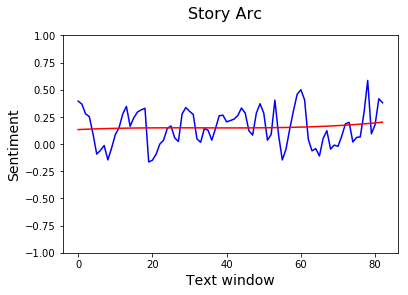

In [47]:
sentiment_graph(0, 3)

In [48]:
cluster_groups = [x[1] for x in clusters]

In [49]:
df['index'] = df.index

for i in range(len(cluster_groups)):
    df['cluster_num' + str(i)] = df['index'].apply(lambda x: 1 if x in cluster_groups[i] else 0)

In [50]:
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,sentiment_range,sentiment_std,sentiment_array_interp,index,cluster_num0,cluster_num1,cluster_num2,cluster_num3,cluster_num4,cluster_num5
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.766667,0.184887,"[0.395, 0.367640582656, 0.277303523035, 0.2526...",0,0,0,0,0,1,0
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,1.002778,0.205259,"[0.34, 0.30243902439, 0.260670731707, -0.02408...",1,0,0,0,0,0,1
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,1.225000,0.173746,"[0.126666666667, 0.118455284553, 0.11032520325...",2,0,0,0,0,1,0
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.813333,0.178260,"[0.0, 0.103983739837, 0.242706155633, 0.001524...",3,0,1,0,0,0,0
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,1.250000,0.209164,"[0.078125, -0.100426829268, 0.0435540069686, 0...",4,0,0,0,1,0,0


In [51]:
# EXPORT DATA
file = 'df_text_122417'
fileobj = open(file,'wb') 
pickle.dump(df,fileobj) 